In [1]:
import torch 

x = torch.Tensor([[0.1513, 0.1034, 0.4494, 0.4344, 0.9990],
         [0.0842, 0.0815, 0.4713, 0.3194, 0.9291],
         [0.0667, 0.0745, 0.5992, 0.8489, 1.0000],
         [0.0373, 0.0551, 0.5486, 0.1089, 0.9995],
         [0.0328, 0.0556, 0.4983, 0.7707, 0.6503],
         [0.0277, 0.0343, 0.3750, 0.9698, 0.9985],
         [0.0103, 0.0219, 0.6110, 0.9342, 0.4759],
         [0.0082, 0.0188, 0.6338, 0.7912, 0.0130],
         [0.0124, 0.0147, 0.3801, 0.3667, 0.7325],
         [0.0136, 0.0143, 0.3729, 0.8628, 0.0335]])
edge_index = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
          3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8],
         [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
          4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]]).long()
edge_attr = torch.Tensor([[0.0714],
         [0.2848],
         [0.2153],
         [0.2049],
         [0.2847],
         [0.3346],
         [0.2759],
         [0.0777],
         [0.2644],
         [0.3049],
         [0.1452],
         [0.2689],
         [0.2270],
         [0.2649],
         [0.3204],
         [0.0919],
         [0.2868],
         [0.1617],
         [0.1074],
         [0.2269],
         [0.0519],
         [0.0477],
         [0.3550],
         [0.2174],
         [0.2063],
         [0.1859],
         [0.1197],
         [0.2054],
         [0.2226],
         [0.2231],
         [0.1672],
         [0.1453],
         [0.1306],
         [0.2651],
         [0.1322],
         [0.2276],
         [0.2701],
         [0.2355],
         [0.0635],
         [0.0876],
         [0.3390],
         [0.2325],
         [0.3502],
         [0.2540],
         [0.2943]])

In [2]:
x.shape,edge_index.shape,edge_attr.shape

(torch.Size([10, 5]), torch.Size([2, 45]), torch.Size([45, 1]))

In [3]:
def debug_init(layer,fill=1.):
    layer.weight.data.fill_(fill)
    layer.bias.data.fill_(fill)

In [4]:
import torch
import torch_geometric as pyg

from torch_geometric.nn import MessagePassing

class GCNConv(pyg.nn.MessagePassing):
    def __init__(self,n,m, debug=False):
        super(GCNConv,self).__init__(aggr='add')
        self.linear = torch.nn.Linear(n,m)
        torch.nn.init.xavier_uniform_(self.linear.weight)
        
        if debug: debug_init(self.linear)
        
    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        
        row, col = edge_index

        #edge_weight = torch.ones((edge_index.size(1), ), device=edge_index.device)
        deg = pyg.utils.degree(row, x.size(0), dtype = x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        # return self.propagate(edge_index,x=x,edge_attr=edge_attr,norm=norm) + torch.nn.functional.relu(x)*1./deg.view(-1,1)
        self.messages = []
        return self.propagate(edge_index,x=x,edge_attr=edge_attr,norm=norm)
    
    def message(self,x_j, edge_attr, norm):
        # return norm.view(-1,1)*torch.nn.functional.relu(x_j+edge_attr)
        msg = torch.nn.functional.relu(x_j+edge_attr)
        self.messages.append((x_j,edge_attr,msg))
        return msg
    
    def update(self,aggr_out):
        return aggr_out

In [ ]:
layer = GCNConv(5,2)

tensor([[0.5000],
        [0.5000],
        [0.5248],
        [0.5075],
        [0.5049],
        [0.5248],
        [0.5372],
        [0.5226],
        [0.5000],
        [0.5197]], grad_fn=<SigmoidBackward>)

In [244]:
def debug_compare(true,test):
    return ((true-test)**2).sum()

In [245]:
def linear(input,weights,biases):
    return torch.Tensor([ [(array*weight).sum()+bias for weight,bias in zip(weights,biases) ] for array in input ])

In [246]:
layer.linear.weight.shape

torch.Size([2, 5])

In [247]:
true_x = layer.linear(x)
new_x = linear(x,layer.linear.weight,layer.linear.bias)
debug_compare(true_x,new_x)

tensor(2.8422e-14, grad_fn=<SumBackward0>)

In [248]:
new_x

tensor([[1.3548, 1.2315],
        [1.3040, 1.1821],
        [1.5334, 1.5598],
        [1.3603, 1.1869],
        [1.1914, 1.2713],
        [1.4196, 1.5970],
        [1.1299, 1.2935],
        [0.7515, 0.8999],
        [1.0887, 1.1138],
        [0.6342, 0.8730]])

In [230]:
x

tensor([[0.1513, 0.1034, 0.4494, 0.4344, 0.9990],
        [0.0842, 0.0815, 0.4713, 0.3194, 0.9291],
        [0.0667, 0.0745, 0.5992, 0.8489, 1.0000],
        [0.0373, 0.0551, 0.5486, 0.1089, 0.9995],
        [0.0328, 0.0556, 0.4983, 0.7707, 0.6503],
        [0.0277, 0.0343, 0.3750, 0.9698, 0.9985],
        [0.0103, 0.0219, 0.6110, 0.9342, 0.4759],
        [0.0082, 0.0188, 0.6338, 0.7912, 0.0130],
        [0.0124, 0.0147, 0.3801, 0.3667, 0.7325],
        [0.0136, 0.0143, 0.3729, 0.8628, 0.0335]])

In [233]:
i = 0
x[i],

NameError: name 'weights' is not defined

In [180]:
def relu(input):
    return torch.Tensor([ [  el if el > 0 else 0 for el in array ] for array in input ])

In [181]:
def message(x,edge_index,edge_attr):
    row,_ = edge_index
    
    return relu(x[row]+edge_attr)

In [182]:
true_msg = layer.messages[0][2]
new_msg = message(new_x,edge_index,edge_attr)
debug_compare(true_msg,new_msg)

tensor(1.2649e-12, grad_fn=<SumBackward0>)

In [252]:
layer.messages[0][2].shape

torch.Size([45, 2])

In [183]:
def scatter_add(x,edge_index,msg):
    out = torch.zeros((x.shape))
    _,col = edge_index
    for e,u in enumerate(col):
        out[u] += msg[e]
    return out

In [184]:
def scatter_max(x,edge_index,msg):
    n_features = x.shape[1]
    out = torch.zeros((x.shape))
    _,col = edge_index
    for e,u in enumerate(col):
        for i in range(n_features):
            out[u,i] = max(out[u,i],msg[e,i])
    return out

In [185]:
new_out = scatter_add(new_x,edge_index,new_msg)
# new_out = scatter_max(new_x,edge_index,new_msg)
debug_compare(true_out,new_out)

tensor(4.0379e-12, grad_fn=<SumBackward0>)

In [191]:
def full_layer(x,edge_index,edge_attr):
    x = linear(x,layer.linear.weight,layer.linear.bias)
    msg = message(x,edge_index,edge_attr)
    out = scatter_add(x,edge_index,msg)
    return out

In [192]:
import sys,git
sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

def to_input(graph):
    return graph.x,graph.edge_index,graph.edge_attr

dataset = gnn.Dataset('data/signal-training',transform=gnn.to_uptri_graph)
len(dataset)

100000

In [214]:
from torch_geometric.loader import DataLoader

training,validation = gnn.train_test_split(dataset,0.2)

trainloader = DataLoader(training[:1000],batch_size=10,shuffle=True,num_workers=4)

In [215]:
def compare_models(graph):
    x,edge_index,edge_attr = to_input(graph)
    true_out = layer(x,edge_index,edge_attr)
    new_out = full_layer(x,edge_index,edge_attr)

    with torch.no_grad():
        return float(debug_compare(true_out,new_out))


In [216]:
comparison = [ compare_models(train) for train in trainloader ]

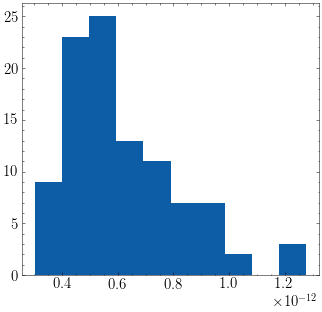

In [217]:
import matplotlib.pyplot as plt
import numpy 

plt.hist(comparison)
plt.show()